# 📘 Deep Hedging — Marché Heston (version complète)

Ce notebook entraîne un réseau neuronal (Deep Hedging) pour couvrir un **call européen** dans un marché Heston.  
Fonctionnalités :
- simulation Heston (Euler, full-truncation)
- réseau (entrée : log(S), tau)
- loss : MSE shortfall ou CVaR (Rockafellar–Uryasev)
- coûts de transaction proportionnels
- entraînement vectorisé + minibatching
- baseline : delta Black-Scholes avec volatilité effective
- visualisations et métriques (RMSE, ES)


In [4]:
!pip install torch pandas numpy matplotlib


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error

## 1) Simulation Heston (Euler - full truncation)


In [6]:
def simulate_heston_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, N, M, seed=42):
    """
    Simule M trajectoires Heston (S_t, v_t) sur N pas (N+1 points) par Euler full-truncation.
    Retourne S (M, N+1), v (M, N+1)
    """
    rng = np.random.default_rng(seed)
    dt = T / N
    S = np.zeros((M, N+1), dtype=np.float64)
    v = np.zeros((M, N+1), dtype=np.float64)
    S[:,0] = S0
    v[:,0] = v0

    for t in range(1, N+1):
        Z1 = rng.standard_normal(M)
        Z2 = rng.standard_normal(M)
        Z2 = rho * Z1 + np.sqrt(max(0.0, 1 - rho**2)) * Z2

        v_prev = np.maximum(v[:, t-1], 0.0)
        # variance step (CIR-like Euler with sqrt)
        v[:, t] = v_prev + kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(np.maximum(v_prev * dt, 0.0)) * Z2
        v[:, t] = np.maximum(v[:, t], 0.0)

        # asset step using previous v (avoid negative inside sqrt)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev * dt, 0.0)) * Z1)

    return S, v


**3. Modèle de couverture (réseau neuronal simple)**


In [7]:

class HedgingNN(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)   # position scalar at time t
        )
    def forward(self, x):
        # x: (B, 2) -> output: (B,1)
        return self.net(x)


## 3) Utilitaires : delta BS robuste, transaction cost, CVaR loss


In [8]:
def bs_delta_call(S, K, tau, r, sigma):
    """
    Delta of European call for vector S and scalar/array tau.
    S : array-like
    tau: time to maturity (can be scalar or array-like same shape as S)
    Returns Nd1.
    """
    S = np.array(S, dtype=np.float64)
    tau = np.array(tau, dtype=np.float64)
    tau_eff = np.maximum(tau, 1e-9)
    d1 = (np.log(np.maximum(S,1e-12) / K) + (r + 0.5 * sigma**2) * tau_eff) / (sigma * np.sqrt(tau_eff))
    return norm.cdf(d1)

def transaction_cost(phi, S_t, rate):
    """
    phi: torch tensor (B, N) positions
    S_t: torch tensor (B, N) prices at times t (start of each interval)
    rate: scalar cost coefficient
    returns: cost per path (B,)
    """
    phi_prev = torch.zeros_like(phi[:, :1])
    dphi = torch.abs(phi - torch.cat([phi_prev, phi[:, :-1]], dim=1))
    cost = rate * (dphi * S_t).sum(dim=1)
    return cost

class CVaRLoss(nn.Module):
    def __init__(self, alpha=0.95, init_eta=0.0):
        super().__init__()
        self.alpha = alpha
        self.eta = nn.Parameter(torch.tensor([init_eta], dtype=torch.float32))
    def forward(self, losses):
        # losses: tensor (B,) representing shortfall per path
        excess = torch.relu(losses - self.eta)
        return self.eta + (1.0 / (1.0 - self.alpha)) * excess.mean()


## 4) Boucle d'entraînement vectorisée (pour S_paths simulées Heston)
- On entraîne sur minibatches de trajectoires.
- Loss calculée sur le shortfall = (payoff - pnl) + lambda * cost.
- Option: risk="mse" or "cvar".


In [9]:
def train_deep_hedging_heston(
    S_paths, K, r, T, model,
    n_epochs=30, lr=1e-3, batch_size=1024,
    risk="cvar", alpha=0.95,
    tc_rate=0.0, tc_lambda=1.0,
    weight_decay=0.0,
    device=None,
    verbose=True,
    seed=123
):
    """
    S_paths: np.array (M, N+1)
    model: HedgingNN instance
    returns: train_losses, shortfall_nn (np array), shortfall_delta (np array)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = model.to(device)
    M, N_plus_1 = S_paths.shape
    N = N_plus_1 - 1
    dt = T / N

    # Precompute tensors
    S_full = torch.tensor(S_paths, dtype=torch.float32, device=device)           # (M, N+1)
    dS_full = S_full[:, 1:] - S_full[:, :-1]                                     # (M, N)
    logS_full = torch.log(S_full[:, :-1])                                        # (M, N)
    tau_vec = torch.linspace(T - dt, dt, N, device=device).unsqueeze(0).expand(M, N)  # (M, N)
    payoff_full = torch.clamp(S_full[:, -1] - K, min=0.0)                         # (M,)

    # risk objective
    if risk.lower() == "cvar":
        risk_obj = CVaRLoss(alpha=alpha).to(device)
        params = list(model.parameters()) + list(risk_obj.parameters())
    else:
        risk_obj = nn.MSELoss(reduction="mean")
        params = list(model.parameters())

    optimizer = optim.Adam(params, lr=lr, weight_decay=weight_decay)

    idx_all = torch.arange(M, device=device)
    train_losses = []

    # Flattened inputs will be created per batch to evaluate model in one forward
    for epoch in range(n_epochs):
        perm = idx_all[torch.randperm(M)]
        epoch_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for start in range(0, M, batch_size):
            end = min(start + batch_size, M)
            idx = perm[start:end]

            S = S_full[idx]            # (B, N+1)
            dS = dS_full[idx]          # (B, N)
            logS = logS_full[idx]      # (B, N)
            tau = tau_vec[idx]         # (B, N)
            payoff = payoff_full[idx]  # (B,)

            B = S.shape[0]
            # features -> (B*N, 2)
            X = torch.stack([logS, tau], dim=-1).reshape(-1, 2)   # (B*N, 2)
            phi = model(X).reshape(B, N)                         # (B, N) positions
            pnl = (phi * dS).sum(dim=1)                          # (B,)

            # transaction cost
            cost = transaction_cost(phi, S[:, :-1], tc_rate) if tc_rate > 0 else torch.zeros_like(pnl)

            # shortfall per path: (payoff - pnl) + lambda*cost
            L = (payoff - pnl) + tc_lambda * cost

            optimizer.zero_grad()
            if risk.lower() == "cvar":
                loss = risk_obj(L)
            else:
                # we want L close to 0 => MSE(L, 0)
                loss = risk_obj(L, torch.zeros_like(L))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / max(1, n_batches)
        train_losses.append(avg_loss)
        if verbose:
            dt_epoch = time.time() - t0
            if risk.lower() == "cvar":
                print(f"Epoch {epoch+1}/{n_epochs} - Loss(CVaR@{alpha:.2f})={avg_loss:.6f} - time {dt_epoch:.1f}s - eta={risk_obj.eta.item():.6f}")
            else:
                print(f"Epoch {epoch+1}/{n_epochs} - Loss(MSE)={avg_loss:.6f} - time {dt_epoch:.1f}s")

    # Evaluation full set
    with torch.no_grad():
        X_full = torch.stack([logS_full, tau_vec], dim=-1).reshape(-1, 2)
        phi_full = model(X_full).reshape(M, N)             # (M,N)
        pnl_full = (phi_full * dS_full).sum(dim=1).cpu().numpy()
        cost_full = transaction_cost(phi_full, S_full[:, :-1], tc_rate).cpu().numpy() if tc_rate > 0 else np.zeros(M)
        shortfall_nn = (payoff_full.cpu().numpy() - pnl_full) + tc_lambda * cost_full

        # baseline delta approx: use effective vol = sqrt(mean(v) ) estimated from trajectories if available (user can pass)
        # Here we approximate vol by empirical std of log-returns aggregated (quick heuristic)
        # Compute per-path delta using bs_delta_call with sigma_eff
        # We'll compute a single scalar sigma_eff from data
        logret = np.log(S_paths[:,1:] / S_paths[:,:-1])
        sigma_eff = np.sqrt(np.mean(logret.var(axis=1))) * np.sqrt(252.0) if logret.size>0 else 0.2
        # but working in continuous time scaling: approximate daily->annual etc. We'll just use sqrt(mean variance)
        # create delta positions grid for whole dataset (M, N)
        t_grid = np.linspace(0, T - (T/N), N)  # time to maturity for each step start
        # use sigma_eff as volatility estimate
        delta_positions = bs_delta_call(S_paths[:, :-1], K, T - t_grid, r, sigma_eff)  # (M,N)
        pnl_delta = (delta_positions * (S_paths[:, 1:] - S_paths[:, :-1])).sum(axis=1)
        payoff_np = np.maximum(S_paths[:, -1] - K, 0.0)
        shortfall_delta = payoff_np - pnl_delta

    return train_losses, shortfall_nn, shortfall_delta, sigma_eff


**6. Paramètres du problème et exécution**

In [11]:
from scipy.stats import norm
import time
# Paramètres Heston
S0 = 100.0
v0 = 0.04              # initial variance
r = 0.0
kappa = 2.0
theta = 0.04
sigma_v = 0.5
rho = -0.7

# Training / discretization
T = 1.0
N = 60
M = 8000               # nombre de trajectoires (adapter selon mémoire)
K = 100.0

# Model + training hyperparams
hidden_dim = 128
n_epochs = 25
lr = 1e-3
batch_size = 1024
risk = "cvar"          # "cvar" ou "mse"
alpha = 0.95
tc_rate = 1e-4         # coût transactionnel (proportionnel)
tc_lambda = 1.0
weight_decay = 1e-6

# Simulate Heston paths
print("Simulating Heston paths...")
S_paths, v_paths = simulate_heston_paths(S0, v0, r, kappa, theta, sigma_v, rho, T, N, M, seed=123)
print("Done. shape S_paths:", S_paths.shape)

# Build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HedgingNN(hidden_dim=hidden_dim)

# Train
train_losses, shortfall_nn, shortfall_delta, sigma_eff = train_deep_hedging_heston(
    S_paths, K, r, T, model,
    n_epochs=n_epochs, lr=lr, batch_size=batch_size,
    risk=risk, alpha=alpha,
    tc_rate=tc_rate, tc_lambda=tc_lambda,
    weight_decay=weight_decay,
    device=device,
    verbose=True,
    seed=123
)
print("Training finished. sigma_eff (heuristic):", sigma_eff)


Simulating Heston paths...
Done. shape S_paths: (8000, 61)
Epoch 1/25 - Loss(CVaR@0.95)=149.450230 - time 2.5s - eta=0.007907
Epoch 2/25 - Loss(CVaR@0.95)=145.037027 - time 2.5s - eta=0.015897
Epoch 3/25 - Loss(CVaR@0.95)=145.541044 - time 2.6s - eta=0.024030
Epoch 4/25 - Loss(CVaR@0.95)=145.475365 - time 1.5s - eta=0.032197
Epoch 5/25 - Loss(CVaR@0.95)=145.041256 - time 1.9s - eta=0.040368
Epoch 6/25 - Loss(CVaR@0.95)=144.381174 - time 2.1s - eta=0.048527
Epoch 7/25 - Loss(CVaR@0.95)=145.133091 - time 1.5s - eta=0.056558
Epoch 8/25 - Loss(CVaR@0.95)=145.872885 - time 1.5s - eta=0.064651
Epoch 9/25 - Loss(CVaR@0.95)=145.147247 - time 1.5s - eta=0.072756
Epoch 10/25 - Loss(CVaR@0.95)=144.385818 - time 1.6s - eta=0.080863
Epoch 11/25 - Loss(CVaR@0.95)=144.625687 - time 1.6s - eta=0.088912
Epoch 12/25 - Loss(CVaR@0.95)=144.830198 - time 1.5s - eta=0.096928
Epoch 13/25 - Loss(CVaR@0.95)=144.760378 - time 2.0s - eta=0.104971
Epoch 14/25 - Loss(CVaR@0.95)=144.628723 - time 2.1s - eta=0.11301

7. **Visualisation des résultats**

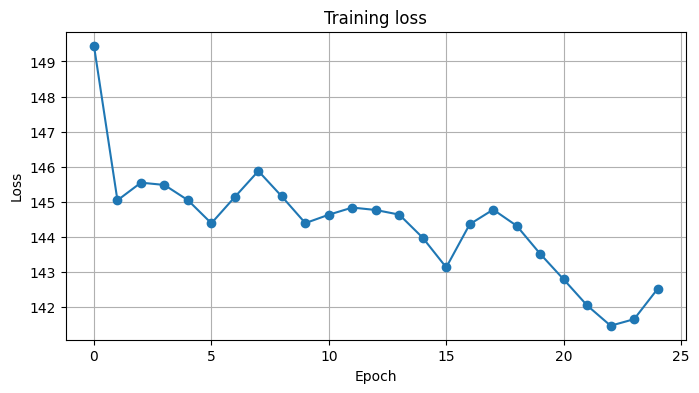

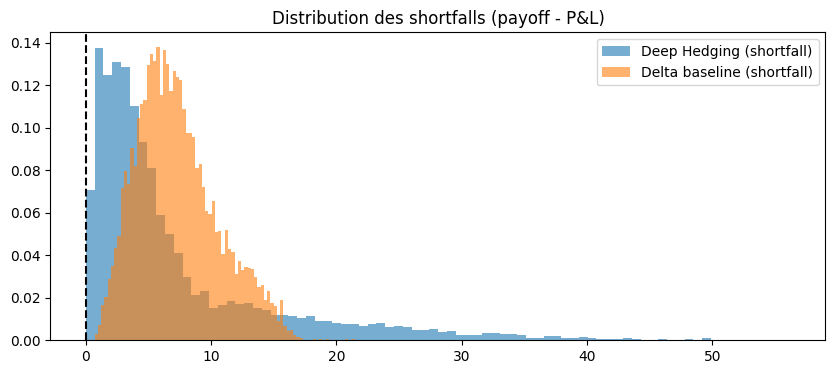

TypeError: got an unexpected keyword argument 'squared'

In [12]:
# Loss curve
plt.figure(figsize=(8,4))
plt.plot(train_losses, marker='o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Histogram shortfalls
plt.figure(figsize=(10,4))
plt.hist(shortfall_nn, bins=80, alpha=0.6, density=True, label="Deep Hedging (shortfall)")
plt.hist(shortfall_delta, bins=80, alpha=0.6, density=True, label="Delta baseline (shortfall)")
plt.axvline(0, color='k', linestyle='--')
plt.legend()
plt.title("Distribution des shortfalls (payoff - P&L)")
plt.show()

# RMSE
rmse_nn = mean_squared_error(np.zeros_like(shortfall_nn), shortfall_nn, squared=False)
rmse_delta = mean_squared_error(np.zeros_like(shortfall_delta), shortfall_delta, squared=False)
print(f"RMSE shortfall - Deep Hedging: {rmse_nn:.6f}")
print(f"RMSE shortfall - Delta baseline: {rmse_delta:.6f}")

# Empirical ES@95% (tail mean of worst 5% losses)
def empirical_es_tail(x, tail_prob=0.95):
    # here shortfall = payoff - pnl; large positive = bad for hedger; we take mean of top (1-alpha) quantile
    q = np.quantile(x, tail_prob)
    tail = x[x >= q]
    return tail.mean() if tail.size>0 else np.nan

es_nn = empirical_es_tail(shortfall_nn, alpha)
es_delta = empirical_es_tail(shortfall_delta, alpha)
print(f"ES@{int(alpha*100)}% shortfall - Deep Hedging: {es_nn:.6f}")
print(f"ES@{int(alpha*100)}% shortfall - Delta baseline: {es_delta:.6f}")


## 7) Sauvegarde du modèle (optionnel)


In [13]:
# Sauvegarde du modèle entraîné (fichier .pt)
torch.save(model.state_dict(), "deep_hedging_heston_model.pt")
print("Model saved to deep_hedging_heston_model.pt")


Model saved to deep_hedging_heston_model.pt


## 8) Remarques & pistes d'amélioration
- La baseline delta est approximative dans un marché Heston ; on pourrait calculer le delta sous la mesure risque-neutre via outils semi-analytiques (plus cher).  
- On a utilisé une heuristique sigma_eff; pour un benchmark plus fin, calculer une implied volatility ou utiliser la moyenne de v_t.  
- On peut enrichir les features : inclure estimateurs de volatilité (p.ex. moyenne mobile de squared returns), historique d'ordres, etc.  
- Pour de meilleures performances, on doit d'ajuster `M`, `batch_size`, `hidden_dim`, `lr`, `tc_rate`.  
- Pour la CVaR, il faut surveillez  `eta` (paramètre appris) ; il donne une idée du seuil de pertes extrêmes.
